In [131]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import tarfile
import random
import dill

from os import listdir
from datetime import datetime
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
tarf = tarfile.open('./fer2013.tar.gz')
tarf.extractall()

In [3]:
emotion_strings = [
    'Angry'      # 0
    , 'Disgust'  # 1
    , 'Fear'     # 2
    , 'Happy'    # 3
    , 'Sad'      # 4
    , 'Surprise' # 5
    , 'Neutral'  # 6
]

def emo_to_string(emotion):
    return emotion_strings[np.argmax(emotion)]

for i in range(7):
    arr = np.zeros(shape=(7))
    arr[i] = 1
    print(emo_to_string(arr))

Angry
Disgust
Fear
Happy
Sad
Surprise
Neutral


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


(35887, 48, 48, 1)


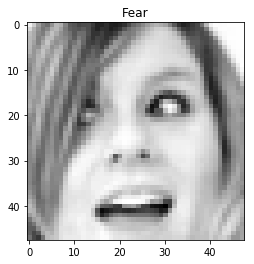

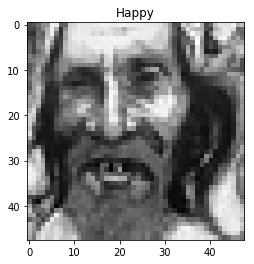

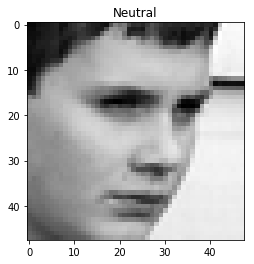

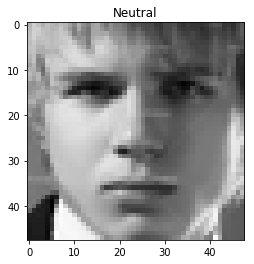

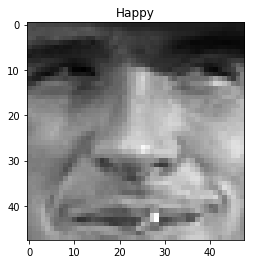

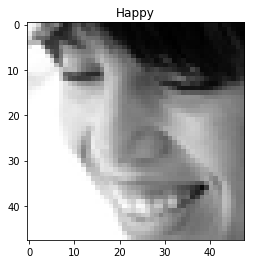

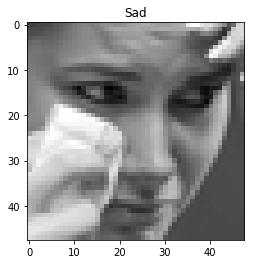

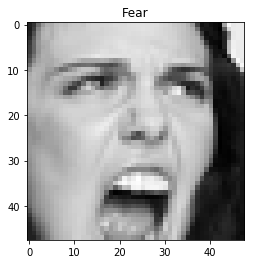

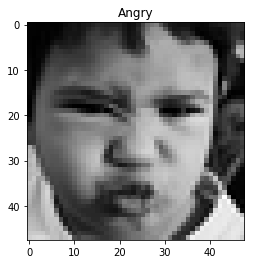

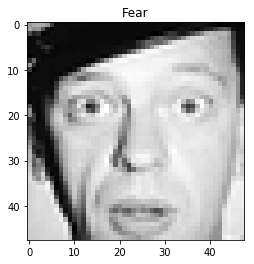

In [4]:
data = pd.read_csv('./fer2013/fer2013.csv')
width = 48
height = 48

# Covert pixels column to a list
pixels = data['pixels'].tolist()
emotions = pd.get_dummies(data['emotion']).as_matrix()

faces = []

for pixel_sequence in pixels:
    # Split the string by space character as a list
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    
    # convert to numpy array
    face = np.asarray(face).reshape(width, height)
    
    faces.append(face.astype('float32'))
    
faces = np.asarray(faces)
# normalize data 
faces /= 255.0
# center data
faces = faces - np.mean(faces)
faces = np.expand_dims(faces, -1)
print(faces.shape)

r = np.random.randint(len(faces), size=10)
for i in r:
    img = faces[i,:,:,0];
    plt.imshow(img, cmap='gray')
    plt.title(emo_to_string(emotions[i]))
    plt.show()

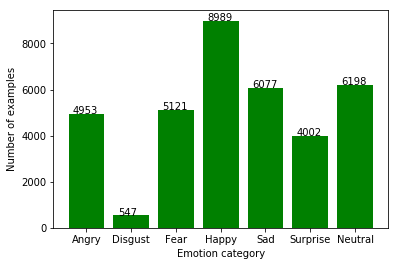

In [5]:
# obtain counts for each of the categories
counts = collections.Counter([np.argmax(row) for row in emotions])

emo_ids = list(counts.keys())
emo_counts = list(list(counts.values()))
bars = plt.bar(emo_ids, emo_counts, color='g')
plt.xticks(emo_ids, [emotion_strings[i] for i in emo_ids])
plt.xlabel("Emotion category")
plt.ylabel("Number of examples")
for i, bar in enumerate(bars):
    y = bar.get_height()
    plt.text(bar.get_x() + 0.1, y + 1, emo_counts[i])
plt.show()

In [6]:
train_count = 28709
val_count = 3589
test_count = 3589
num_channels = 1
num_classes = 7

perm = np.random.permutation(faces.shape[0])
train_dataset = faces[perm[:train_count]]
train_labels = emotions[perm[:train_count]]
valid_dataset = faces[perm[train_count:train_count+val_count]]
valid_labels = emotions[perm[train_count:train_count+val_count]]
test_dataset = faces[perm[train_count+val_count:]]
test_labels = emotions[perm[train_count+val_count:]]

print('Train: %s %s' % (train_dataset.shape, train_labels.shape))
print('Validation: %s %s' % (valid_dataset.shape, valid_labels.shape))
print('Test: %s %s' % (test_dataset.shape, test_labels.shape))

Train: (28709, 48, 48, 1) (28709, 7)
Validation: (3589, 48, 48, 1) (3589, 7)
Test: (3589, 48, 48, 1) (3589, 7)


In [120]:
def conv2d(x, W, b, train, strides=1):
    conv = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    conv = tf.nn.bias_add(conv, b)
    return tf.nn.relu(conv)     

def maxpool2d(x, k=2, strides=1):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], 
                          strides=[1, strides, strides, 1], padding='SAME')

# r1 -> filter for reduce of 3x3
# r2 -> filter for reduce of 5x5
# w1 -> 1x1 filter
# w3 -> 3x3 filter
# w5 -> 5x5 filter
# wp -> 1x1 pool proj filters
# b -> bias
def inception(x, weights, bias):
    # 1x1
    one_by_one = tf.nn.conv2d(x, weights['w1'], strides=[1,1,1,1], padding='SAME')
    one_by_one = tf.nn.relu(one_by_one)
    
    # 3x3
    three_by_three_red = tf.nn.conv2d(x, weights['r1'], 
                                      strides=[1,1,1,1], padding='SAME')
    three_by_three_red = tf.nn.relu(three_by_three_red)
    three_by_three = tf.nn.conv2d(three_by_three_red, weights['w3'],
                                  strides=[1,1,1,1], padding='SAME')
    three_by_three = tf.nn.relu(three_by_three)
    
    # 5x5
    five_by_five_red = tf.nn.conv2d(x, weights['r2'], 
                                    strides=[1,1,1,1], padding='SAME')
    five_by_five_red = tf.nn.relu(five_by_five_red)
    five_by_five = tf.nn.conv2d(five_by_five_red, weights['w5'],
                                strides=[1,1,1,1], padding='SAME')
    five_by_five = tf.nn.relu(five_by_five)
    
    # Projection pooling
    max_pool = tf.nn.max_pool(x, ksize=[1,3,3,1], strides=[1,1,1,1], padding='SAME')    
    pooling = tf.nn.conv2d(max_pool, weights['wp'],
                           strides=[1,1,1,1], padding='SAME')
    pooling = tf.nn.relu(pooling)
    
    out = tf.concat([one_by_one, three_by_three, five_by_five, pooling], axis=3)
    out = tf.nn.bias_add(out, bias)
    
    return tf.nn.relu(out)
    

Implementation of the solution proposed in https://arxiv.org/pdf/1511.04110.pdf
Architecture consists of:


*  2 traditional CNN modules
*  2 Inception-style modules



In [8]:
def accuracy(predictions, labels):
    equality = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(equality, tf.float32))

In [124]:
def neural_net(x, weights, biases, train, keep_prob=0.5):
    
    conv1 = conv2d(x, weights['conv1'], biases['conv1'], train, strides=2)
    conv1 = maxpool2d(conv1, k=3, strides=2)
    
    conv2 = conv2d(conv1, weights['conv2'], biases['conv2'], train, strides=1)
    conv2 = maxpool2d(conv2, k=3, strides=2)
    
    inc_a = inception(conv2, weights['incept_a'], biases['incept_a'])
    
    inc_b = inception(inc_a, weights['incept_b'], biases['incept_b'])
    inc_b = maxpool2d(inc_b, k=3, strides=2)
    
    inc_c = inception(inc_b, weights['incept_c'], biases['incept_c'])
    inc_c = tf.nn.avg_pool(inc_c, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    
    fc1 = tf.reshape(inc_c, [-1, weights['fc1'].get_shape().as_list()[0]])
    fc1 = tf.matmul(fc1, weights['fc1']) + biases['fc1']
    fc1 = tf.nn.relu(fc1)
#     fc1 = batch_normalization(fc1, biases['fc1'], train, conv_layer=False)
    
    if(train == True):
        fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)
    
    fc2 = tf.matmul(fc1, weights['fc2']) + biases['fc2'] 
    fc2 = tf.nn.relu(fc2)
#     fc2 = batch_normalization(fc2, biases['fc2'], train, conv_layer=False)
    
    if(train == True):
        fc2 = tf.nn.dropout(fc2, keep_prob=keep_prob)
    
    out = tf.matmul(fc2, weights['out']) + biases['out'] 
    return tf.nn.relu(out)

def nn(x, w, b):
    fc1 = tf.reshape(x, [-1, w['fc1'].get_shape().as_list()[0]])
    fc1 = tf.matmul(fc1, w['fc1']) + b['fc1']
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.matmul(fc1, weights['fc2']) + biases['fc2'] 
    fc2 = tf.nn.relu(fc2)
    
    out = tf.matmul(fc2, weights['out']) + biases['out']
    
    return tf.nn.relu(out)

def batch_normalization(x, offset, train, conv_layer=True):
    Ybn = tf.layers.batch_normalization(x, training=train, momentum=0.9)
#     exp_moving_avg = tf.train.ExponentialMovingAverage(0.999)
#     bnepsilon = 1e-5
    
#     if conv_layer:
#         mean, variance = tf.nn.moments(x, [0, 1, 2])
#     else:
#         mean, variance = tf.nn.moments(x, [0])
        
#     update_moving_everages = exp_moving_avg.apply([mean, variance])
    
#     m = tf.cond(train, lambda: mean, lambda: exp_moving_avg.average(mean))
#     v = tf.cond(train, lambda: variance, lambda: exp_moving_avg.average(variance))
#     Ybn = tf.nn.batch_normalization(x, m, v, offset, None, bnepsilon)
    return Ybn

In [133]:
graph = tf.Graph()
# initializer=tf.contrib.layers.variance_scaling_initializer()
initializer = tf.contrib.layers.xavier_initializer()
keep_prob = 0.5
beta = 0.9

with graph.as_default(), tf.device('/gpu:0'):
    weights = {
        'conv1': tf.get_variable('W_conv1', shape=(7,7,1,64), 
                           initializer=initializer),
        'conv2': tf.get_variable('W_conv2', shape=(3,3,64,192), 
                           initializer=initializer),
        'incept_a' : {
            'r1': tf.get_variable('incept_a_r3x3', shape=(1,1,192,96), 
                          initializer=initializer),
            'r2': tf.get_variable('incept_a_r5x5', shape=(1,1,192,16), 
                          initializer=initializer),
            'w1': tf.get_variable('incept_a_1x1', shape=(1,1,192,64), 
                          initializer=initializer),
            'w3': tf.get_variable('incept_a_3x3', shape=(3,3,96,128), 
                          initializer=initializer),
            'w5': tf.get_variable('incept_a_5x5', shape=(5,5,16,32), 
                          initializer=initializer),
            'wp': tf.get_variable('incept_a_w', shape=(1,1,192,32), 
                          initializer=initializer)
        },
        'incept_b': {
            'r1': tf.get_variable('incept_b_r3x3', shape=(1,1,256,128), 
                          initializer=initializer),
            'r2': tf.get_variable('incept_b_r5x5', shape=(1,1,256,32), 
                          initializer=initializer),
            'w1': tf.get_variable('incept_b_1x1', shape=(1,1,256,128), 
                          initializer=initializer),
            'w3': tf.get_variable('incept_b_3x3', shape=(3,3,128,192), 
                          initializer=initializer),
            'w5': tf.get_variable('incept_b_5x5', shape=(5,5,32,96), 
                          initializer=initializer),
            'wp': tf.get_variable('incept_b_w', shape=(1,1,256,64), 
                          initializer=initializer),
        },
        'incept_c' : {
            'r1': tf.get_variable('incept_c_r3x3', shape=(1,1,480,96), 
                          initializer=initializer),
            'r2': tf.get_variable('incept_c_r5x5', shape=(1,1,480,16), 
                          initializer=initializer),
            'w1': tf.get_variable('incept_c_1x1', shape=(1,1,480,192), 
                          initializer=initializer),
            'w3': tf.get_variable('incept_c_3x3', shape=(3,3,96,208), 
                          initializer=initializer),
            'w5': tf.get_variable('incept_c_5x5', shape=(5,5,16,48), 
                          initializer=initializer),
            'wp': tf.get_variable('incept_c_w', shape=(1,1,480,64), 
                          initializer=initializer),
        },    
        'fc1': tf.get_variable('W_fc1', shape=(2048,4096), 
                       initializer=initializer),
#         'fc1': tf.get_variable('W20', shape=(2304,4096), 
#                        initializer=tf.contrib.layers.xavier_initializer()),
        'fc2': tf.get_variable('W_fc2', shape=(4096,1024), 
                       initializer=initializer),
        'out': tf.get_variable('W_out', shape=(1024,7), 
                       initializer=initializer)
    }
    biases = {
        'conv1': tf.get_variable('B0', shape=(64), 
                       initializer=tf.zeros_initializer()),
        'conv2': tf.get_variable('B1', shape=(192), 
                        initializer=tf.zeros_initializer()),
        'incept_a': tf.get_variable('B2', shape=(256), 
                            initializer=tf.zeros_initializer()),
        'incept_b': tf.get_variable('B3', shape=(480), 
                            initializer=tf.zeros_initializer()),
        'incept_c': tf.get_variable('B4', shape=(512), 
                            initializer=tf.zeros_initializer()),
        'fc1': tf.get_variable('B5', shape=(4096), 
                       initializer=tf.zeros_initializer()),
        'fc2': tf.get_variable('B6', shape=(1024),
                       initializer=tf.zeros_initializer()),
        'out': tf.get_variable('B7', shape=(7), 
                       initializer=tf.zeros_initializer())
    }
    
    tf_train_dataset = tf.placeholder(tf.float32, [None, width, height, num_channels])
    tf_train_labels = tf.placeholder(tf.float32, [None, num_classes])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_valid_labales = tf.constant(valid_labels)
    tf_test_dataset = tf.constant(test_dataset)
    tf_test_labels = tf.constant(test_labels)
    iteration = tf.placeholder(tf.int32)
    train = tf.constant(True, tf.bool)
    test = tf.constant(False, tf.bool)
    
#     logits = neural_net(tf_train_dataset, weights, biases)
    logits = neural_net(tf_train_dataset, weights, biases, keep_prob=0.5, train=train)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    tf_loss_summary = tf.summary.scalar('loss', loss)
    
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.01
    end_learning_rate = 0.0001
    decay_steps = 1000
    learning_rate = tf.train.polynomial_decay(starter_learning_rate, global_step,
                                          decay_steps, end_learning_rate,
                                          power=0.5)
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=beta).minimize(loss)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    train_prediction = tf.nn.softmax(logits)
    train_accuracy = accuracy(train_prediction, tf_train_labels)
    tf_train_acc_sum = tf.summary.scalar('train_accuracy', train_accuracy)
    
    merged_train_sum = tf.summary.merge([tf_loss_summary, tf_train_acc_sum])
    
    valid_prediction = tf.nn.softmax(neural_net(tf_valid_dataset, weights, biases, train=test))
    valid_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=valid_prediction, labels=valid_labels))
    valid_accuracy = accuracy(valid_prediction, valid_labels)
    tf_valid_loss_sum = tf.summary.scalar('validation_loss', valid_loss)
    tf_valid_acc_sum = tf.summary.scalar('validation_accuracy', valid_accuracy)
    valid_summary = tf.summary.merge([tf_valid_loss_sum, tf_valid_acc_sum])
    
    test_prediction = tf.nn.softmax(neural_net(tf_test_dataset, weights, biases, train=test))
    test_accuracy = accuracy(test_prediction, test_labels)

In [137]:
batch_size = 250
num_steps = 150000
step = 0 # current step of the training
train_writer = tf.summary.FileWriter("logs/scalars/train/dropout-0.5-momentum-augment-" + datetime.now().strftime("%Y-%m-%d-%H%M%S"))
valid_writer = tf.summary.FileWriter("logs/scalars/valid/dropout-0.5-momentum-augment-" + datetime.now().strftime("%Y-%m-%d-%H%M%S"))

datagen = ImageDataGenerator(featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=30,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.2,
                        horizontal_flip=True)
datagen.fit(train_dataset)

with tf.Session(graph=graph, config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    tf.global_variables_initializer().run()
    test_writer = tf.summary.FileWriter("graphs", sess.graph)
    for batch, labels in datagen.flow(train_dataset, train_labels, shuffle=False, batch_size=batch_size):
#         start = (step*batch_size)%train_count
#         end = (start+batch_size)%train_count
#         batch = train_dataset[start:end]
#         labels = train_labels[start:end]
        _, l, pred, summary, acc = sess.run([optimizer, loss, train_prediction, 
                                        merged_train_sum, train_accuracy],
                             feed_dict={tf_train_dataset: batch,
                                       tf_train_labels: labels})
        train_writer.add_summary(summary, step)
        if(step%500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Validation accuracy %f' % (valid_accuracy.eval()))
            print('Minibatch accuracy %f' % (acc))
            val_summary = sess.run(valid_summary)
            valid_writer.add_summary(val_summary, step)
        if(step >= num_steps):
            break
        step = step + 1
    print("Test accuracy: %f" % (test_accuracy.eval()))

Minibatch loss at step 0: 1.947499
Validation accuracy 0.056283
Minibatch accuracy 0.024000
Minibatch loss at step 500: 1.857014
Validation accuracy 0.264140
Minibatch accuracy 0.232000
Minibatch loss at step 1000: 1.747266
Validation accuracy 0.315687
Minibatch accuracy 0.344000
Minibatch loss at step 1500: 1.668489
Validation accuracy 0.414322
Minibatch accuracy 0.352000
Minibatch loss at step 2000: 1.554315
Validation accuracy 0.468097
Minibatch accuracy 0.352000
Minibatch loss at step 2500: 1.290475
Validation accuracy 0.513235
Minibatch accuracy 0.484000
Minibatch loss at step 3000: 1.294124
Validation accuracy 0.523544
Minibatch accuracy 0.492000
Minibatch loss at step 3500: 1.207032
Validation accuracy 0.556980
Minibatch accuracy 0.524000
Minibatch loss at step 4000: 1.143093
Validation accuracy 0.555029
Minibatch accuracy 0.560000
Minibatch loss at step 4500: 1.160272
Validation accuracy 0.553357
Minibatch accuracy 0.532000
Minibatch loss at step 5000: 1.055291
Validation accur

In [209]:
graph = tf.Graph()


with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[], name="x")
    y = tf.Variable(tf.zeros(shape=[2]), dtype=tf.float32, name="y")
    z = x+y
    saver = tf.train.Saver()

    
with tf.Session(graph=graph) as sess:
    
    tf.global_variables_initializer().run()
    l=4.0
    t = sess.run(z, feed_dict={x: l})
    saver.save(sess, 'tmp/model.ckpt')
    print(t)
    
    inputs_dict = {
                "x": l
    }
    outputs_dict = {
                "z": t
    }
    tf.saved_model.simple_save(
                sess, 'tmp/model', inputs_dict, outputs_dict
            )

[4. 4.]


AttributeError: 'float' object has no attribute 'dtype'

## print(t)

In [186]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    loader = tf.train.import_meta_graph('tmp/model.ckpt.meta')
    loader.restore(sess, 'tmp/model.ckpt')
    graph = tf.get_default_graph()
    g = z.eval()
    print(g)

INFO:tensorflow:Restoring parameters from tmp/model.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Variable_3 not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-140-2d6472d20ff6>:9) ]]

Caused by op 'save/RestoreV2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1424, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 126, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-140-2d6472d20ff6>", line 9, in <module>
    saver = tf.train.Saver()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 832, in __init__
    self.build()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 844, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 881, in _build
    build_save=build_save, build_restore=build_restore)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 513, in _build_internal
    restore_sequentially, reshape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 332, in _AddRestoreOps
    restore_sequentially)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py", line 580, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 1572, in restore_v2
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key Variable_3 not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-140-2d6472d20ff6>:9) ]]
